In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
sns.set_style("whitegrid")
db_url = os.getenv("DATABASE_URL")
engine = create_engine(db_url)

query = 'SELECT * FROM "ANALYTICAL_MAINTENANCE" ORDER BY timestamp_clean ASC'
df = pd.read_sql(query, engine)

print(f"Data loaded: {df.shape}")
display(df.head())

# class balance
failure_counts = df['machine_failure'].value_counts()
print("\nFailures:")
print(failure_counts)
print(f"\nFailure rate: {(failure_counts[1] / len(df)) * 100:.2f}%")

Data loaded: (10000, 15)


,udi,product_id,timestamp_clean,machine_type,machine_failure,tool_wear,air_temperature,process_temperature,rotational_speed,torque,avg_air_temp_1h,rot_speed_stability_1h,torque_change_instant,temp_differential,operational_status
0,1,M14860,2024-01-01 08:00:00,M,0,0,298.1,308.6,1551.0,42.8,298.100000,0.000000,NaN,10.5,Normal
1,2,L47181,2024-01-01 08:05:00,L,0,3,298.2,308.7,1408.0,46.3,298.150000,101.116270,3.5,10.5,Unstable
2,3,L47182,2024-01-01 08:10:00,L,0,5,298.1,308.5,1498.0,49.4,298.133333,72.293384,3.1,10.4,Unstable
3,4,L47183,2024-01-01 08:15:00,L,0,7,298.2,308.6,1433.0,39.5,298.150000,64.634872,-9.9,10.4,Unstable
4,5,L47184,2024-01-01 08:20:00,L,0,9,298.2,308.7,1408.0,40.0,298.160000,62.970628,0.5,10.5,Unstable



Failures:
machine_failure
0    9661
1     339
Name: count, dtype: int64

Failure rate: 3.39%


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

features_to_drop = ['udi', 'product_id', 'timestamp_clean', 'machine_failure', 'operational_status']

X = df.drop(columns=features_to_drop)
y = df['machine_failure']

# machine type to numbers
le = LabelEncoder()
X['machine_type'] = le.fit_transform(X['machine_type'])

print("Features:")
print(X.columns.tolist())

# time-based split
train_size = int(len(df) * 0.8)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

print(f"Training set: {X_train.shape[0]} rows")
print(f"Test Set: {X_test.shape[0]} rows")

print(f"Failures in Train: {y_train.sum()}")
print(f"Failures in Test:  {y_test.sum()}")

Features:
['machine_type', 'tool_wear', 'air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'avg_air_temp_1h', 'rot_speed_stability_1h', 'torque_change_instant', 'temp_differential']
Training set: 8000 rows
Test Set: 2000 rows
Failures in Train: 300
Failures in Test:  39


In [3]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# imbalanced class weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Weight: {ratio:.2f}")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train);

Weight: 25.67



MODEL EVAL - TEST SET
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1961
           1       0.47      0.67      0.55        39

    accuracy                           0.98      2000
   macro avg       0.73      0.83      0.77      2000
weighted avg       0.98      0.98      0.98      2000



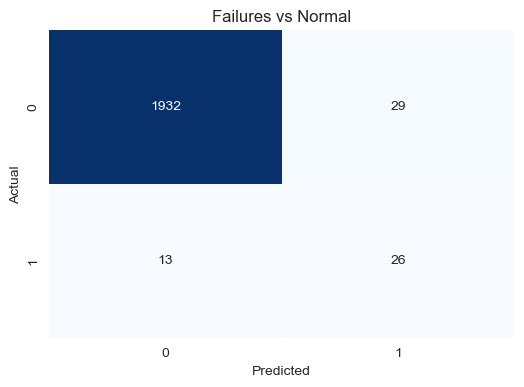

ROC-AUC score: 0.9605


In [4]:
# predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# metrics
print("\nMODEL EVAL - TEST SET")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Failures vs Normal')
plt.show()

# roc-auc
roc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC score: {roc:.4f}")

VIRTUAL SENSOR EVAL
Target: Process Temperature
RMSE: 0.1597 K
R2 Score: 0.9770


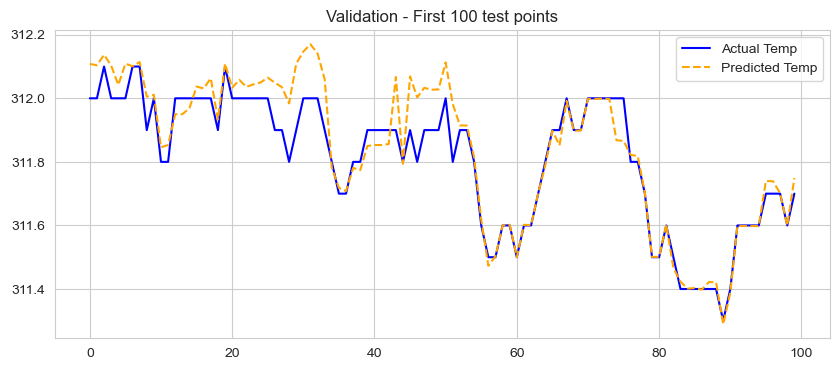

In [5]:
# virtual sensor for process temperature for anomalies
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# air temp, speed, torque, tool wear -> process temp
y_reg = df['process_temperature']
X_reg = df.drop(columns=['udi', 'product_id', 'timestamp_clean', 'machine_failure', 
                         'operational_status', 'process_temperature'])

# encode machine_type
X_reg['machine_type'] = le.fit_transform(X_reg['machine_type'])

# time-based split
X_reg_train = X_reg.iloc[:train_size]
y_reg_train = y_reg.iloc[:train_size]
X_reg_test = X_reg.iloc[train_size:]
y_reg_test = y_reg.iloc[train_size:]

# random forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_reg_train, y_reg_train)

# eval
y_reg_pred = regressor.predict(X_reg_test)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"VIRTUAL SENSOR EVAL")
print(f"Target: Process Temperature")
print(f"RMSE: {rmse:.4f} K")
print(f"R2 Score: {r2:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(y_reg_test.values[:100], label='Actual Temp', color='blue')
plt.plot(y_reg_pred[:100], label='Predicted Temp', color='orange', linestyle='--')
plt.title("Validation - First 100 test points")
plt.legend()
plt.show()

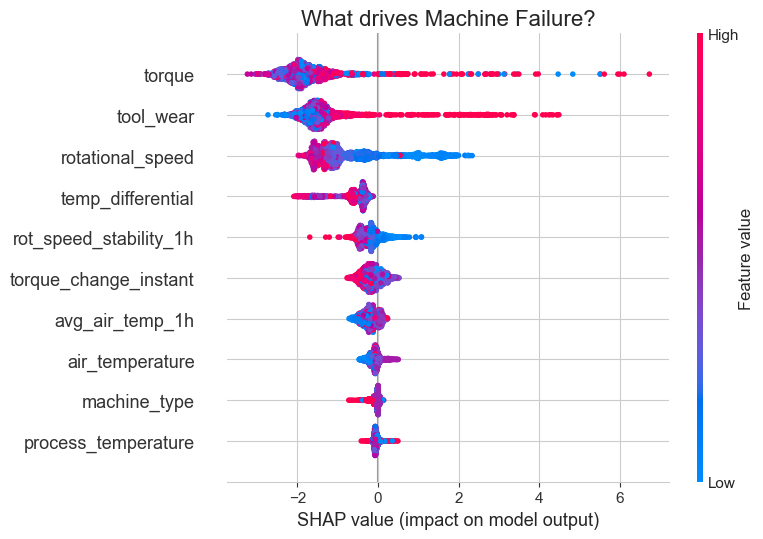

In [6]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("What drives Machine Failure?", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
import joblib

if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump(model, '../models/xgb_classifier.joblib')
joblib.dump(regressor, '../models/rf_regressor.joblib')
joblib.dump(le, '../models/label_encoder.joblib')

print("Models saved")

Models saved
